In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# import os
# os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async" # this seems to be highly important for totally utilizing your GPU's memory, but it also breaks the profiler's memory breakdown
# note that GradientTape needs several times the memory needed to compute the fidelity of a single circuit
import tensorflow as tf
import numpy as np
import qutip as qt
from bingo.optimizer.tf_adam_optimizer import AdamOptimizer
from bingo.gate_sets import SQRCRRDispGateSet
from bingo.optimizer.GateSynthesizer import GateSynthesizer
import matplotlib.pyplot as plt


Need tf version 2.3.0 or later. Using tensorflow version: 2.7.0



In [4]:
N_cav = 25
alpha = 1.5
a = qt.tensor(qt.identity(2),qt.destroy(N_cav))
q = qt.tensor(qt.destroy(2),qt.identity(N_cav))
S = a**4 / alpha**4
I = qt.tensor(qt.identity(2),qt.identity(N_cav))
g = 0.001
H = (S - I).dag()*q + (S-I)*q.dag()
U = (-1j*H).expm()

fock_cut = 5
init_states = []
target_states = []
for i in range(fock_cut):
    psi0 = qt.tensor(qt.basis(2, 0),qt.basis(N_cav, i))
    psit = U*psi0
    init_states.append(psi0)
    target_states.append(psit)

In [6]:
rho0 = qt.ket2dm(qt.tensor(qt.basis(2, 0),qt.basis(N_cav, 0)))
rhos = [rho0]
rounds = 100
for i in range(rounds):
    rho = rhos[-1]
    rho_c = qt.ptrace(U*rho*U.dag(), 1)
    rho = qt.tensor(qt.ket2dm(qt.basis(2, 0)),rho_c)
    rhos.append(rho)

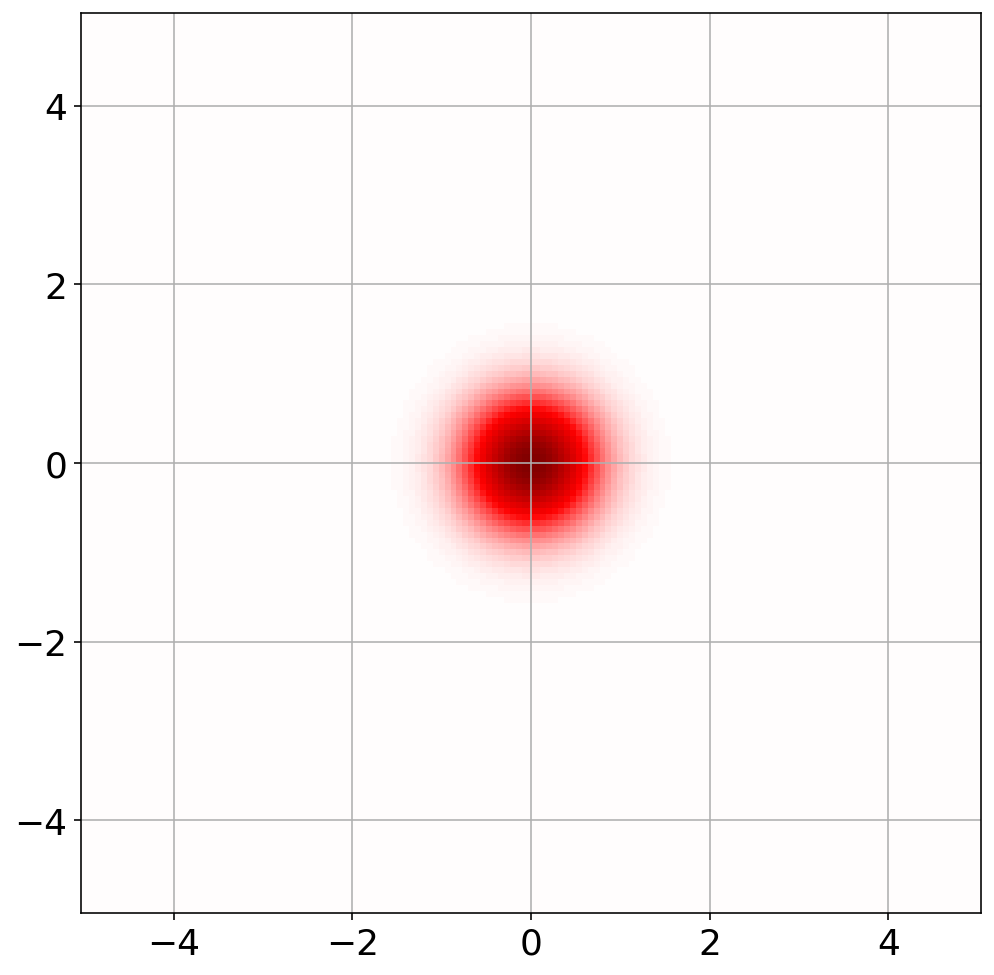

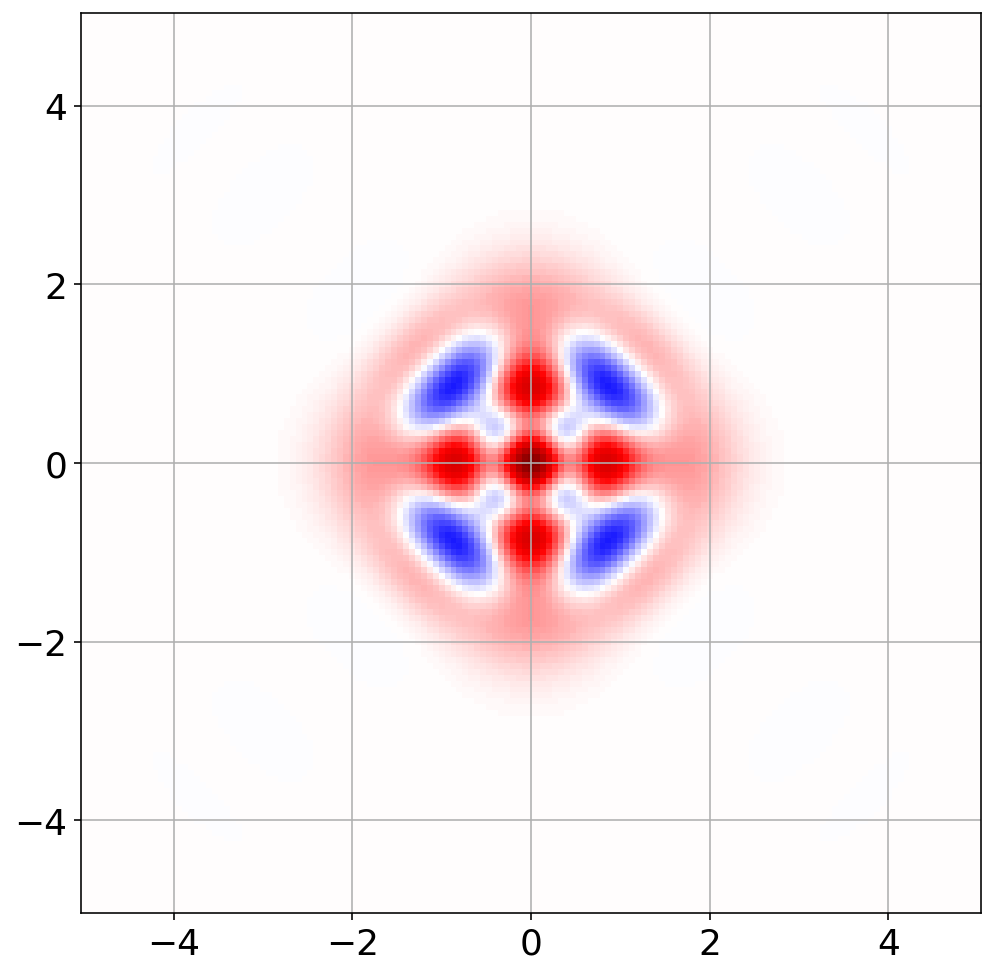

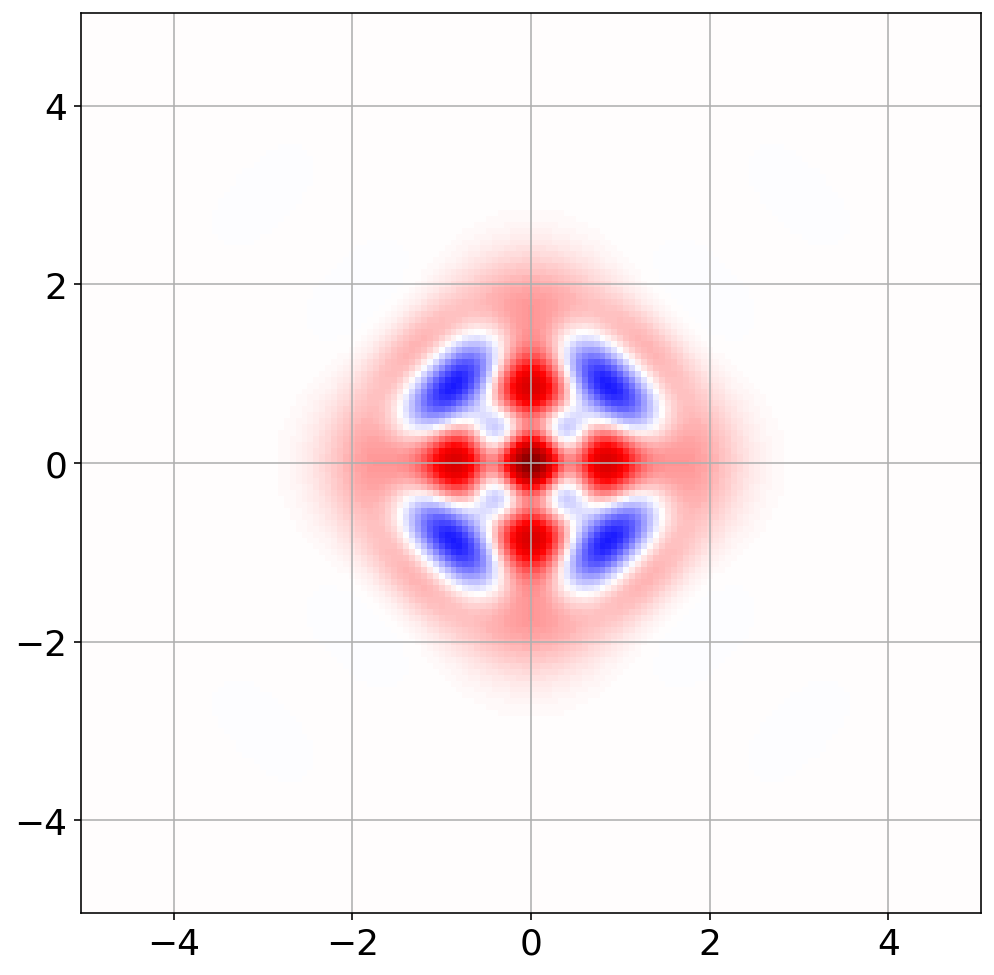

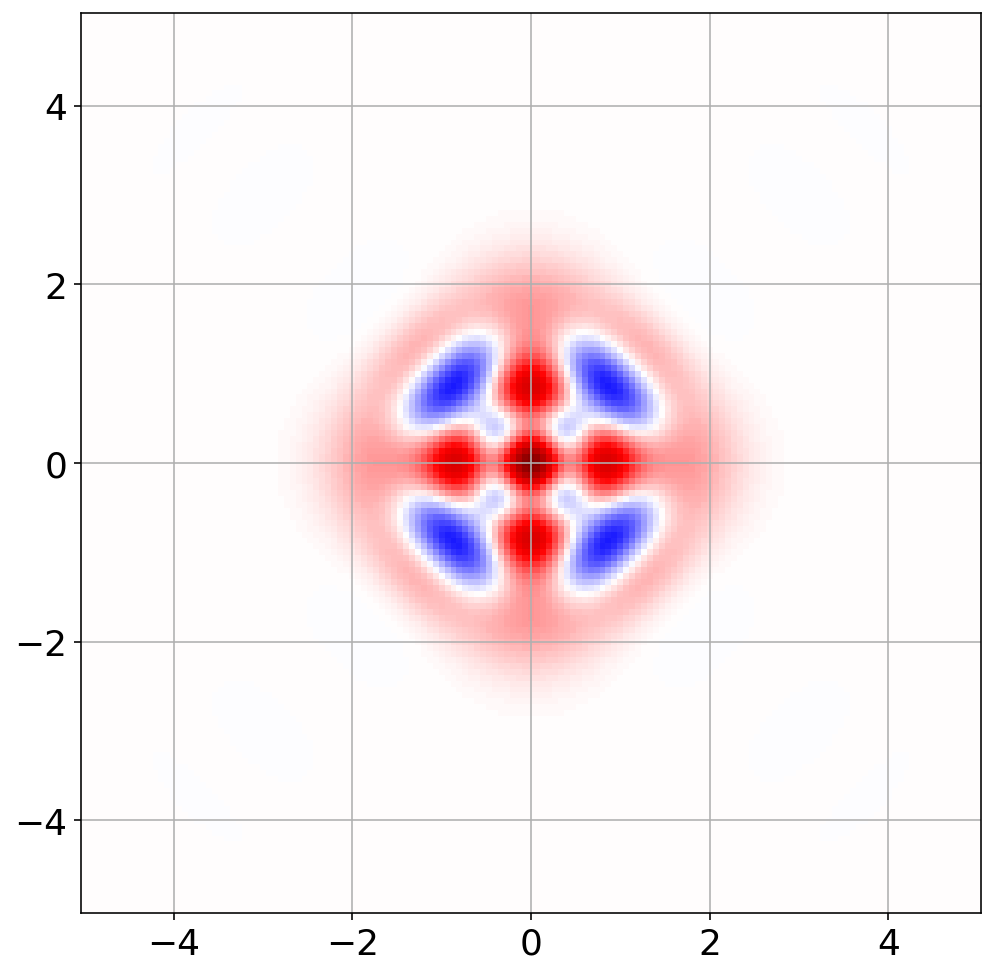

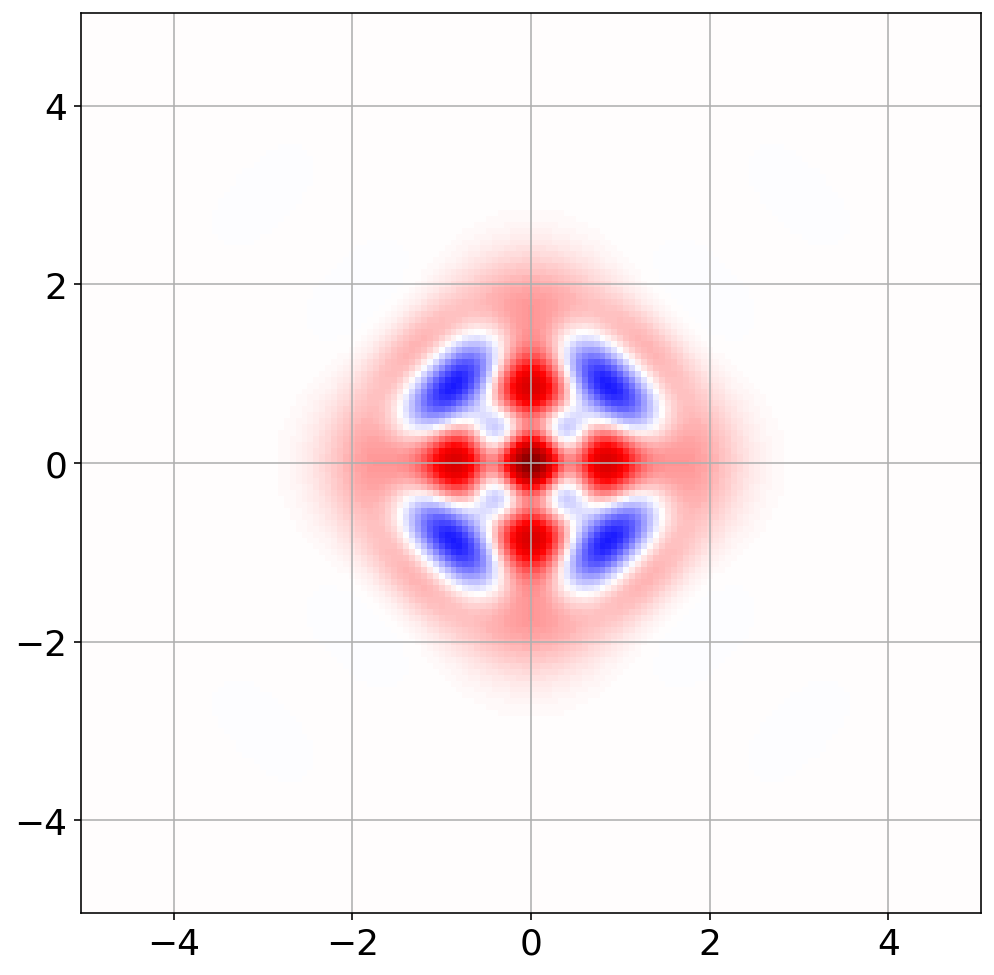

In [8]:
from Bosonic_tools.plotting_tools import plot_wigner
for rho in rhos[::25]:
    plot_wigner(rho.ptrace(1))

In [16]:
# We initialize the gateset here
gate_set_params = {
    'N_cav' : N_cav,
    'alpha_scale' : 1.0, #maximum |beta| for random initialization  
    'N_SQR':12
}
gate_set = SQRCRRDispGateSet(**gate_set_params)

In [17]:
synth_params = {
    'gateset':gate_set,
    'N_blocks': 6, # note that the length of the pulse is number of control points
    'N_multistart' : 100, #Batch size (number of circuit optimizations to run in parallel)
    'epochs' : 600, #number of epochs before termination
    'epoch_size' : 5, #number of adam steps per epoch
    'learning_rate' : 0.1, #adam learning rate
    'term_fid' : 0.999, #0.995, #terminal fidelitiy
    'dfid_stop' : 1e-6, #stop if dfid between two epochs is smaller than this number
    'initial_states' : init_states, #qubit tensor oscillator, start in |g> |0>
    'target_states' : target_states, #end in |e> |target>.
    'name' : 'four cat SQR', #name for printing and saving
    'coherent' : True,
    'filename' : None, #if no filename specified, results will be saved in this folder under 'name.h5'
}
gatesynth = GateSynthesizer(**synth_params)

In [18]:
#create optimization object. 
#initial params will be randomized upon creation
opt = AdamOptimizer(gatesynth)

#print optimization info. this lives in gatesynth, since we eventually want to fully abstract away the optimizer
gatesynth.best_fidelity()

0.0731169

In [19]:
#run optimizer.
#note the optimizer can be stopped at any time by interrupting the python consle,
#and the optimization results will still be saved and part of the opt object.
#This allows you to stop the optimization whenever you want and still use the result.
# Note that you will not want to use the performance profiler while using 'inplace' mode. You will run out of memory
opt.optimize()#logdir='logs')

Start time: 2022-09-16 00:52:45
 Epoch: 600 / 600 Max Fid: 0.995783 Avg Fid: 0.976242 Max dFid: 0.024974 Avg dFid: 0.000250 Elapsed time: 0:03:40.367077 Expected remaining time: 0:00:000.367296

Optimization stopped.  Reached maximum number of epochs. Terminal fidelity not reached.

N_blocks: 6
optimization_type: state transfer
optimization_masks: {'alphas_rho': None, 'alphas_angle': None, 'phis': None, 'thetas': None, 'SQR_phis': None, 'SQR_thetas': None, 'CR_thetas': None}
target_unitary: None
expectation_operators: None
target_expectation_values: None
N_multistart: 100
term_fid: 0.999
dfid_stop: 1e-06
learning_rate: 0.1
epoch_size: 5
epochs: 600
name: four cat SQR
filename: None
comment: 
coherent: True
timestamps: ['2022-09-16 00:48:31', '2022-09-16 00:51:45', '2022-09-16 00:52:45']
do_prints: True
filename: four cat SQR.h5

Best circuit parameters found:
alphas:    tf.Tensor(
[ 0.28259+0.19407j -0.60122+0.66543j -0.2037 -0.22107j  0.59797-0.69317j
  0.43407-0.0894j  -0.18017+0.192

'2022-09-16 00:52:45'

In [59]:
import h5py
f = h5py.File('GRAPE Fock 1.h5', 'r')
pulse_obj = f[list(f.keys())[len(list(f.keys())) - 1]] # get the latest key
fids = pulse_obj['fidelities']
# list(f.keys())
pulse_idx = np.argmax(np.amax(fids, axis=0))
controls = []
for k in range(1):
    controls.append(np.array(pulse_obj['I' + str(k)][-1, pulse_idx, :]))
    controls.append(np.array(pulse_obj['Q' + str(k)][-1, pulse_idx, :]))
DAC_time_resolution = 2 # in ns
pulse_len = controls[0].shape[0] * DAC_time_resolution
times = np.arange(pulse_len, step = DAC_time_resolution, dtype=float)
fids[-1, pulse_idx]

0.9991089

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Drive / $\\chi$')

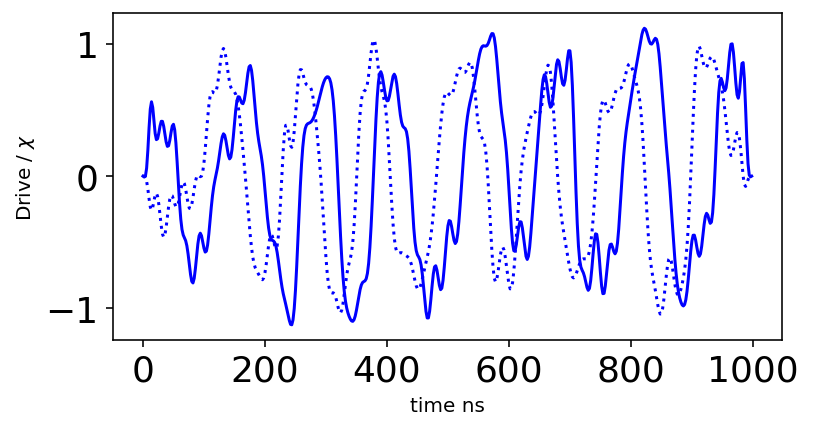

In [60]:
plt.figure(figsize=(6,3))
plt.plot(times, controls[0], 'b-')
plt.plot(times, controls[1], 'b:')
plt.xlabel(r'time ns')
plt.ylabel(r'Drive / $\chi$')

Text(0, 0.5, 'Mag')

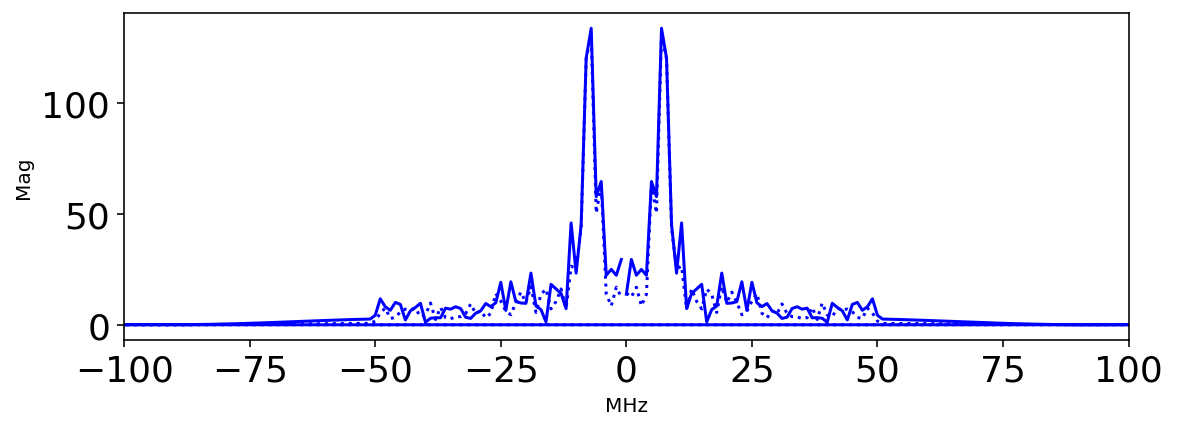

In [61]:
plt.figure(figsize=(9,3))
plt.plot(np.fft.fftfreq(len(controls[0]), DAC_time_resolution) * 1000, np.abs(np.fft.fft(controls[0])), 'b-')
plt.plot(np.fft.fftfreq(len(controls[0]), DAC_time_resolution) * 1000, np.abs(np.fft.fft(controls[1])), 'b:')
plt.xlabel(r'MHz')
plt.xlim(-100, 100)
plt.ylabel(r'Mag')
# plt.yscale('log')